In [17]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'
import glob
import numpy as np
import pandas as pd
#from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec


In [18]:
## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def gwpstar(arr,coeff1,coeff2,gwp100):
    arr_init = coeff1*arr[0:19]*gwp100
    gwparr = np.copy(arr)
    gwparr[20:gwparr.shape[0]] = coeff1*(arr[20:arr.shape[0]]*gwp100)-coeff2*(arr[0:gwparr.shape[0]-20]*gwp100)
    gwparr[0:19] = arr_init
    return(gwparr)

#### ======== Set the paths ========####

# Path for netcdf files
data_path = 'C:/Users/mastr/Documents/LSCE/ACC2_simulations'                        ## WINDOWS
#data_path = '/Users/mmastro/Documents/LSCE/Carbon Budget'               ## MAC OS

# Path for the output files (images, etc)
out_path = "C:/Users/mastr/Documents/LSCE/RESULTS/Carbon_Budget_BETA&Q10_COU"
#out_path = '/Users/mmastro/Documents/LSCE/RESULTS'


## Constants
MttoGt = 0.001
CtoCO2 = 44/12
NtoN2O = 44/14
CO2toC = 12/44

## Simulations with alternate fixed CH4 and CO2 emissions

Here ACC2 acts as an Emulator of ESMs

### Open Data

Please note that CH4 only 1.5 °C simulations are run until 2300, rather than 2500

In [19]:
path = "/ACC2_ssp_rcp_standard_overshoot_CO2_15/"
all_files = []
all_files = glob.glob(os.path.join(data_path + path +"out_future_IPSL_co2_1.5_*_beta03.csv"))
# df = pd.concat((pd.read_csv(f, delim_whitespace=True) for f in all_files), ignore_index=True)

dfs = list()
for f in all_files:
    data = pd.read_csv(f,  delim_whitespace=True)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['SCEN'] = os.path.basename(f).split('_')[4]
    data['TARGET'] = os.path.basename(f).split('_')[5]
    data['DR'] = os.path.basename(f).split('_')[6]
    dfs.append(data)
df_co2_15 = pd.concat(dfs, ignore_index=True)

# Convert TARGET and DR columns to integers
df_co2_15.TARGET = df_co2_15.TARGET.astype(int)
df_co2_15.DR = df_co2_15.DR.astype(int)

# Define sets of targets and discount rates values
targets = sorted(df_co2_15["TARGET"].unique())
drates = sorted(df_co2_15["DR"].unique())


Overview

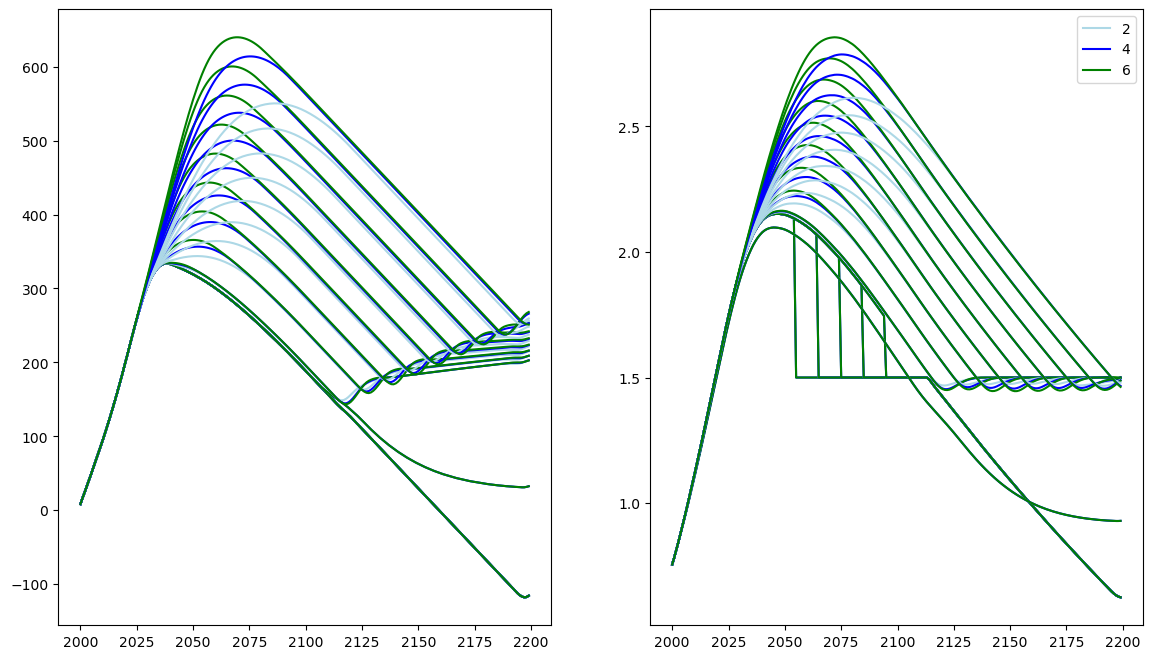

In [20]:
targets = sorted(map(int, (df_co2_15["TARGET"].unique())))
drates = sorted(map(int, (df_co2_15["DR"].unique())))

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(1, 2)

colors = ['lightblue','blue','green','orange','red','brown']
ax = fig.add_subplot(gs[0, 0])
for scn in targets:
    for i,dr in enumerate(list(drates)):
        data = df_co2_15[df_co2_15["TARGET"] == scn]
        year = data[data['DR'] == dr]["YEAR"]
        em = data[data['DR'] == dr]["ANTCO2"].cumsum()
        c = colors[i]
        ax.plot(year[0:200],em[0:200], color = c)

ax = fig.add_subplot(gs[0, 1])
for scn in targets:
    for i,dr in enumerate(list(drates)):
        data = df_co2_15[df_co2_15["TARGET"] == scn]
        year = data[data['DR'] == dr]["YEAR"]
        em = data[data['DR'] == dr]["T2M"]#.cumsum()
        c = colors[i]
        ax.plot(year[0:200],em[0:200], color = c)

    ax.legend(drates)

### CO2 carbon budget

In [21]:
df_OS_co2_15 = pd.DataFrame(columns = ['TARGET', 'DR', 'T2M_OS', 'GHG_OS', 'CO2_OS', 'CH4_OS', 'DURATION'])
df_OS_co2_15.TARGET = targets
df_OS_co2_15=df_OS_co2_15.reindex(df_OS_co2_15.index.repeat(len(drates)))

dfs = []
for scn in targets:

    # Assign DR values for every target
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'DR'] = np.array(drates)

    data = df_co2_15[df_co2_15["TARGET"] == scn].copy()

    overshoot = []; osco2 = []; osch4 = []; t2m_os = []
    tcre_pos = []; tcre_neg = []; tcreplus_pos = []; tcreplus_neg = []; duration = []
    for dr in drates:

        data1 = data[data["DR"] == dr]
        # Cumulative CO2 emissions
        data1['CUMCO2'] = np.cumsum(data1.ANTCO2)
        # Cumulative CH4 emissions
        data1['CUMCH4'] = np.cumsum(gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        # Cumulative N2O emissions
        data1['CUMN2O'] = np.cumsum(data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        # Cumulative CO2+CH4 emissions
        data1['CUMGHG'] = data1['CUMCO2']+data1['CUMCH4']+data1['CUMN2O']
        # Total GHG
        data1['GHG'] = (data1.ANTCO2) + (gwpstar(data1.ANTCH4.to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC) + (data1['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)

        ## OVERSHOOT calculation
        maxt2m = (data1["T2M"]).idxmax()
        beforeos = (data1["T2M"].loc[:maxt2m] <= 1.5).iloc[::-1].idxmax()       # Last data before passing 2 °C
        afteros = (data1["T2M"].loc[maxt2m:] > 1.5).iloc[::-1].idxmax()+1       # First data after returning  to 2 °C 
        # Peak temperature
        peak = (data1.T2M[50:]).idxmax()
        # Threshold exceeding GHG Carbon Budget
        over = (data1['CUMGHG'][afteros] - data1['CUMGHG'][data1['CUMGHG'].index[0]+20])
        overco2 = (data1['CUMCO2'][afteros] - data1['CUMCO2'][data1['CUMCO2'].index[0]+20])
        overch4 = (data1['CUMCH4'][afteros] - data1['CUMCH4'][data1['CUMCH4'].index[0]+20])
        # Temperature overshoot
        t2m_over = (data1['T2M'][peak] - 1.5)
        # Duration of overshoot
        yrs = data1["YEAR"][afteros] - data1["YEAR"][beforeos]
        
        duration.append(yrs)
        overshoot.append(over)
        osco2.append(overco2)
        osch4.append(overch4)
        t2m_os.append(t2m_over)

        ## TCRE calculation
        # Peak cumghg
        maximum = (data1['GHG']<0).idxmax()
        # Lowest Peak cumghg
        minimum = data1[data1['YEAR'] == (2000 + scn -1)].index[0]
        # TCRE+ and TCRE-
        tplus_pos = (data1['T2M'][maximum]/data1['CUMGHG'][maximum])*1000
        tplus_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMGHG'][minimum] - data1['CUMGHG'][maximum]))*1000
        t_pos = (data1['T2M'][maximum]/data1['CUMCO2'][maximum])*1000
        t_neg = ((data1['T2M'][minimum] - data1['T2M'][maximum])/(data1['CUMCO2'][minimum] - data1['CUMCO2'][maximum]))*1000
        # Populate the list
        tcre_pos.append(t_pos)
        tcre_neg.append(t_neg)
        tcreplus_pos.append(tplus_pos)
        tcreplus_neg.append(tplus_neg)

        dfs.append(data1)

    # Populate the dataframe with overshoot amounts
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'DURATION'] = np.array(duration)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'GHG_OS'] = np.array(overshoot)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'CO2_OS'] = np.array(osco2)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'CH4_OS'] = np.array(osch4)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'T2M_OS'] = np.array(t2m_os)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCRE+'] = np.array(tcre_pos)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCRE-'] = np.array(tcre_neg)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCREplus+'] = np.array(tcreplus_pos)
    df_OS_co2_15.loc[df_OS_co2_15['TARGET'] == scn, 'TCREplus-'] = np.array(tcreplus_neg)
df_tcre_co2_15 = pd.concat(dfs, ignore_index=True)

In [22]:
df_OS_co2_15 = df_OS_co2_15[(df_OS_co2_15.TARGET == 126) | (df_OS_co2_15.TARGET == 156) | (df_OS_co2_15.TARGET == 186)]
df_OS_co2_15 = df_OS_co2_15[(df_OS_co2_15.DR == 2) | (df_OS_co2_15.DR == 4) | (df_OS_co2_15.DR == 6)]
df_co2_15 = df_co2_15[(df_co2_15.TARGET == 126) | (df_co2_15.TARGET == 156) | (df_co2_15.TARGET == 186)]
df_co2_15 = df_co2_15[(df_co2_15.DR == 2) | (df_co2_15.DR == 4) | (df_co2_15.DR == 6)]

In [34]:
print("TCRE+ mean value is: ",
    df_OS_co2_15['TCREplus+'].mean().round(1))
print("TCRE- mean value is: ",
    df_OS_co2_15['TCREplus-'].mean().round(1))


TCRE+ mean value is:  3.5
TCRE- mean value is:  5.3


Text(800, 1.6, 'TCRE + :3.5\n TCRE - :5.3')

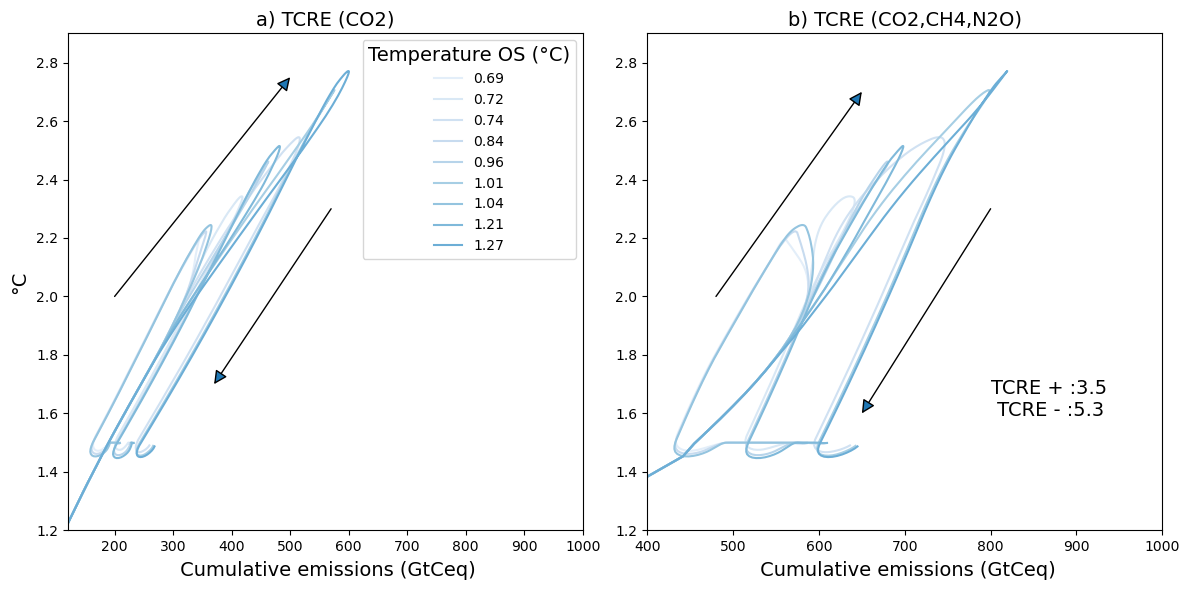

In [55]:
## -------------------- PLOT ---------------------##
title = 'ACC2 1.5 degC target CO2 & CH4 - TCRE, IPSL emulation'

# Plot configuration
width_inch = 12
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

# Plot Ratio N/P
# xlabel = 'Overshoot Amount'
# ylabel = 'Ratio'
# xlabelpad = 5
# ylabelpad = 5
# ax = fig.add_subplot(gs[0, 0])
# ax.plot(OS_ch4_15[7:],ratio_ch4_15[7:], marker='o')
# ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
# ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
# ax.set_title("Ratio N/P emissions")

# Plot TCRE CO2
xlabel = ' Cumulative emissions (GtCeq)'
ylabel = '°C'
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 0])
ax.set_title("a) TCRE (CO2)", size = 14)
prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0)

color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(ticks_co2_15))))
for dr in [2,4,6]:
    for scn in [126, 156, 186]:
        c = next(color)
        data = df_co2_15
        data = data[data["DR"] == dr]
        data = data[data["TARGET"] == scn]
        temp = data["T2M"]
        cumco2 = data["ANTCO2"].cumsum()
        em = cumco2
        ax.plot(em[0:200],temp[0:200], label=overshoot, color=c)
ax.annotate("", xytext=(200, 2), xy=(500,2.75),  xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(570, 2.3), xy=(370,1.7), xycoords = 'data', arrowprops=prop)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_xlim(120,1000)
ax.set_ylim(1.2,2.9)
ax.set_ylabel(ylabel, labelpad=ylabelpad, fontsize=14)
legend = df_OS_co2_15.T2M_OS.astype(float).round(2).astype(str)
ax.legend(legend, loc='upper right',title = "Temperature OS (°C)", title_fontsize = 14, fontsize=10)

# Plot TCRE CO2+CH4+N2O
xlabelpad = 5
ylabelpad = 5
ax = fig.add_subplot(gs[0, 1])
ax.set_title("b) TCRE (CO2,CH4,N2O)", size = 14)
color = iter(cm.Blues_r(np.linspace(0.9, 0.5, len(ticks_co2_15))))
for dr in [2,4,6]:
    for scn in [126, 156, 186]:
        c = next(color)
        data = df_co2_15
        data = data[data["DR"] == dr]
        data = data[data["TARGET"] == scn]
        temp = data["T2M"]
        cumco2 = data["ANTCO2"].cumsum()
        cumch4 = np.cumsum(gwpstar(data["ANTCH4"].to_numpy()*MttoGt ,4.53,4.25,28)*CO2toC)
        cumn2o = np.cumsum(data['ANTN2O']*265*NtoN2O*MttoGt*CO2toC)
        em = cumco2+cumch4+cumn2o
        ax.plot(em[0:200],temp[0:200], label=overshoot, color=c)
ax.annotate("", xytext=(480, 2), xy=(650,2.7), xycoords = 'data', arrowprops=prop)
ax.annotate("", xytext=(800, 2.3), xy=(650,1.6), xycoords = 'data', arrowprops=prop)
ax.set_xlabel(xlabel, labelpad=xlabelpad, fontsize=14)
ax.set_xlim(400,1000)
ax.set_ylim(1.2,2.9)
ax.text(800, 1.6,'TCRE + :3.5\n TCRE - :5.3', wrap = True, size = 14)


# output file
# fig.suptitle(title, fontsize = 14)
# output_file = os.path.join(out_path,title.replace(' ','_')) + "OS_em_4plots.png"

# save the output file
# plt.savefig(output_file)